In [5]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from ast import literal_eval
from fitter import Fitter
from scipy.stats import expon
from collections import Counter

In [6]:
# MICHAEL PATHS

In [7]:
depmap = "/users/michael/Downloads/depmap_interval_files/"
pcawg_tcga = "/users/michael/Downloads/pcawg_tcga_cutoff_passed_interval_files/"
ccle = "/Users/michael/Downloads/amplicon_repo_datasets/ccle_aggregated_results.csv"

In [8]:
# KYRA PATHS

In [13]:
depmap = "/mnt/c/Users/Owner/OneDrive/Documents/BENG_Senior_Design/DepMap/data/depmap_interval_files/"
pcawg_tcga = "/mnt/c/Users/Owner/OneDrive/Documents/BENG_Senior_Design/DepMap/data/pcawg_tcga_cutoff_passed_interval_files/"
ccle = "/mnt/c/Users/Owner/OneDrive/Documents/BENG_Senior_Design/DepMap/data/ccle_aggregated_results.csv"

In [14]:
# get ecDNA features list from depmap, pcawg, tcga datasets

In [15]:
files = [depmap + i for i in os.listdir(depmap)] + [pcawg_tcga + i for i in os.listdir(pcawg_tcga)]

In [16]:
depmap_pcawg_tcga_features = []
for f in files:
    depmap_pcawg_tcga_features.append(pd.read_csv(f, sep='\t', header=None))

In [7]:
# get ecDNA features list from ccle dataset

In [17]:
ccle_df = pd.read_csv(ccle)

In [18]:
ccle_ecdna = ccle_df[ccle_df["Classification"] == "ecDNA"]

In [19]:
ccle_features = []

for __,feature in ccle_ecdna.iterrows():
    # Find all matches (for multiple occurrences per row)
    matches = re.findall(r"'?(chr[\dXY]+):(\d+)-(\d+)'?", feature['Location'])
    if len(matches) > 0:
        df = pd.DataFrame(matches, columns=[0, 1, 2])
        df[1] = pd.to_numeric(df[1])
        df[2] = pd.to_numeric(df[2])
        ccle_features.append(df)

In [20]:
# combine features lists and report counts

In [21]:
all_features = depmap_pcawg_tcga_features + ccle_features

In [22]:
len(depmap_pcawg_tcga_features), len(ccle_features) # 1302, 361 features
len(all_features) # 1663 total features
sum([len(feature) for feature in all_features]) # 7115 intervals

7115

In [23]:
# constants (in bp)

In [24]:
MERGE_DIST = 50000
MIN_LEN = 10000

In [25]:
# function to clean intervals

In [26]:
def merge_and_drop(features):
    num_dropped = 0
    num_merged = 0
    interval_lengths = []
    
    for feature in features:
        interval_lengths_in_feature = []
        
        # store intervals as list of lists
        processed = []
        for __, interval in feature.iterrows():
            processed.append(interval.tolist())
        
        # merge intervals < MERGE_DIST apart
        running_total = processed[0][2] - processed[0][1]
        for i in range(len(processed)):            
            # add last interval to first interval in interval_lengths_in_feature if merge criteria met
            if i == len(processed)-1:
                interval_lengths_in_feature.append(running_total)

            # if the next interval is sufficiently close to this one
            elif processed[i][0] == processed[i+1][0] and processed[i+1][1]-processed[i][2]<=MERGE_DIST:
                # add the next to merged length
                length = processed[i+1][2]-processed[i+1][1]
                running_total += length
                num_merged += 1
                
            else:
                interval_lengths_in_feature.append(running_total)
                length = processed[i+1][2]-processed[i+1][1]
                running_total = length
                    
        # drop intervals < MIN_LEN bp
        interval_lengths_to_add = [i for i in interval_lengths_in_feature if i > MIN_LEN]
        interval_lengths = interval_lengths + interval_lengths_to_add
        num_dropped += len(interval_lengths_in_feature) - len(interval_lengths_to_add)
    
    # report cleaning stats
    print(f"Intervals merged (closer than {MERGE_DIST} bp apart): {num_merged}")
    print(f"Intervals dropped (fewer than {MIN_LEN} bp long): {num_dropped}")
    
    return interval_lengths

In [27]:
interval_lengths = merge_and_drop(all_features)

Intervals merged (closer than 50000 bp apart): 2193
Intervals dropped (fewer than 10000 bp long): 672


In [28]:
len(interval_lengths) # 4250 intervals after cleaning

4250

In [29]:
# YAY done! gl w interviews :>

In [30]:
# ----------------------------- END 02.06.25 SESSION -----------------------------

In [33]:
# ----------------------------- BEGIN Kyra 02.11.25 SESSION -----------------------------

In [36]:
lengths_merged_df = pd.DataFrame(interval_lengths, columns=['Lengths'])

In [37]:
lengths_merged_df.describe()

,Lengths
count,4.250000e+03
mean,8.074900e+05
std,1.364654e+06
min,1.001700e+04
25%,9.051650e+04
50%,3.054355e+05
75%,9.109910e+05
max,1.437193e+07


2025-02-11 14:53:06.600 | WARNING  | fitter.fitter:_fit_single_distribution:337 - SKIPPED _fit distribution (taking more than 30 seconds)
2025-02-11 14:53:06.652 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted alpha distribution with error=0.0)
2025-02-11 14:53:06.664 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted anglit distribution with error=0.0)
2025-02-11 14:53:06.708 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted bradford distribution with error=0.0)
2025-02-11 14:53:06.713 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted arcsine distribution with error=0.0)
2025-02-11 14:53:06.732 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted argus distribution with error=0.0)
2025-02-11 14:53:06.779 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.0)
2025-02-11 14:53:06.834 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted betaprime distribution

             sumsquare_error          aic          bic  kl_div  ks_statistic  \
fatiguelife     3.041885e-14  3886.406535  3905.470558     inf      0.025238   
lognorm         3.055084e-14  3747.413236  3766.477259     inf      0.036980   
johnsonsu       3.061815e-14  3749.792558  3775.211255     inf      0.037128   
johnsonsb       3.113267e-14  3769.196450  3794.615147     inf      0.029613   
fisk            7.146999e-14  3732.598715  3751.662738     inf      0.030808   

             ks_pvalue  
fatiguelife   0.008755  
lognorm       0.000017  
johnsonsu     0.000016  
johnsonsb     0.001134  
fisk          0.000613  


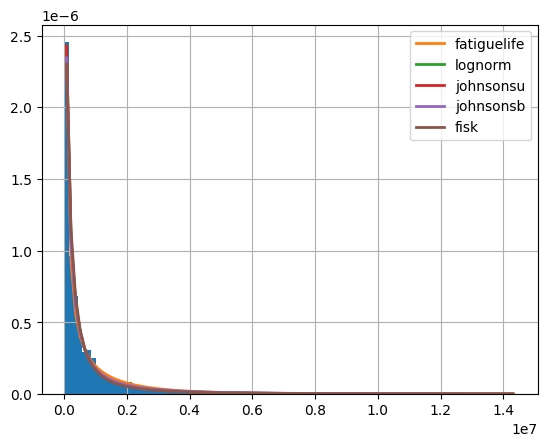

/home/kfetter/.local/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1260: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


In [38]:
f = Fitter(lengths_merged_df)
f.fit()
print(f.summary())

2025-02-11 14:54:03.815 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.0)


       sumsquare_error          aic         bic  kl_div  ks_statistic  \
expon     1.950293e-12  4522.768772  4535.47812     inf      0.198531   

           ks_pvalue  
expon  2.818041e-147  


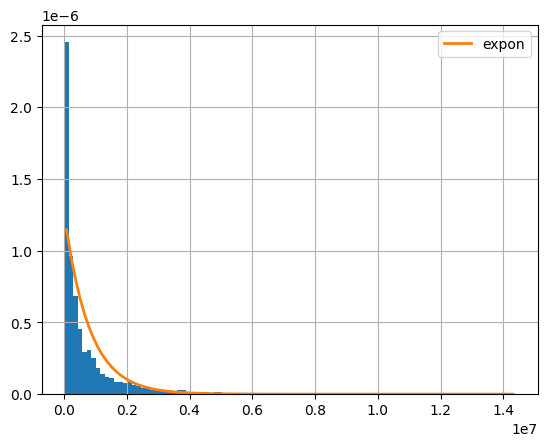

In [39]:
f = Fitter(lengths_merged_df, distributions=['expon'])
f.fit()
print(f.summary())

2025-02-11 14:54:05.116 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted gamma distribution with error=0.0)


       sumsquare_error  aic  bic  kl_div  ks_statistic  ks_pvalue
gamma     7.995979e-12  inf  inf     NaN      0.999764        0.0


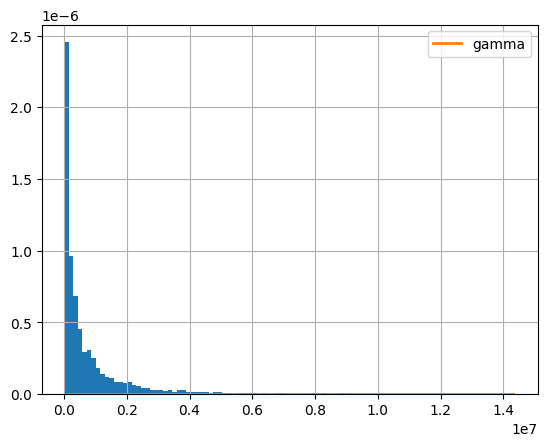

In [40]:
f = Fitter(lengths_merged_df, distributions=['gamma'])
f.fit()
print(f.summary())

In [44]:
loc, scale = expon.fit(lengths_merged_df)

lambda_param = 1/scale

print(f"Fitted lambda: {lambda_param}, loc: {loc}, scale: {scale}")

#test_value = 

#cdf = expon.cdf(test_value, loc=loc, scale=scale)

#1-cdf

Fitted lambda: 1.2539609010506298e-06, loc: 10017.0, scale: 797473.0305882352


In [31]:
# Code following has not been organized

In [ ]:
# MERGE ALGORITHM TOY EXAMPLE

MERGE_DIST = 1
MIN_LEN = 1
    
processed = [(1,8,10), (5,2,4), (1,13,15), (1,16,20), (1,2,4)]
interval_lengths_in_feature = []

running_total = processed[0][2] - processed[0][1]
            
for i in range(len(processed)):
    # add last interval to first interval in interval_lengths_in_feature if merge criteria met
    if i == len(processed)-1:
        interval_lengths_in_feature.append(running_total)

    # if the next interval is sufficiently close to this one
    elif processed[i][0] == processed[i+1][0] and processed[i+1][1]-processed[i][2]<=MERGE_DIST:
        print(i)
        # add the next to merged length
        length = processed[i+1][2]-processed[i+1][1]
        running_total += length
        if length < 0:
            print("OH NO")
    else:
        interval_lengths_in_feature.append(running_total)
        length = processed[i+1][2]-processed[i+1][1]
        running_total = length
        if length < 0:
            print("OH NO")
        
interval_lengths_in_feature

In [ ]:
MERGE_DIST = 50000
MIN_LEN = 10000

# merge intervals < MERGE_DIST apart,
# then drop intervals < MIN_LEN long
def merge_and_drop(input_list):
    interval_lengths = []
    
    for feature in input_list:
        # convert to list
        intervals = literal_eval(feature)
        nonempty = len(intervals) > 0 and intervals != ['']
        # compute length of each interval
        if nonempty:
            processed = []
            interval_lengths_in_feature = []
            
            for interval in intervals:
                # extract interval info
                pattern = r"chr(\d+|X):(\d+)-(\d+)"
                match = re.search(pattern, interval)
                if match:
                    chr_num, start, end = match.groups()
                else:
                    print(f"No match found for {interval}")
                processed.append((chr_num, int(start), int(end)))
                
            running_total = processed[0][2] - processed[0][1]
            
            for i in range(len(processed)):
                # add last interval to first interval in interval_lengths_in_feature if merge criteria met
                if i == len(processed)-1:
                    interval_lengths_in_feature.append(running_total)

                # if the next interval is sufficiently close to this one
                elif processed[i][0] == processed[i+1][0] and processed[i+1][1]-processed[i][2]<=MERGE_DIST:
                    # add the next to merged length
                    length = processed[i+1][2]-processed[i+1][1]
                    running_total += length
                    if length < 0:
                        print("OH NO")
                else:
                    interval_lengths_in_feature.append(running_total)
                    length = processed[i+1][2]-processed[i+1][1]
                    running_total = length
                    if length < 0:
                        print("OH NO")
                    
            interval_lengths_to_add = [i for i in interval_lengths_in_feature if i > MIN_LEN]
            interval_lengths = interval_lengths + interval_lengths_to_add
        
    return interval_lengths

In [ ]:
lengths_merged = merge_and_drop(locations)

In [ ]:
min(lengths_merged), max(lengths_merged)

In [ ]:
lengths_merged_df = pd.DataFrame(lengths_merged, columns=['Numbers'])

In [ ]:
lengths_merged_df.describe()

In [ ]:
f = Fitter(lengths_merged_df)
f.fit()
print(f.summary())

In [ ]:
f = Fitter(lengths_merged_df, distributions=['expon'])
f.fit()
print(f.summary())

In [ ]:
f = Fitter(lengths_merged_df, distributions=['gamma'])
f.fit()
print(f.summary())

In [ ]:
# function to extract lengths from input list
def process_intervals(input_list):
    interval_lengths = []
    feature_lengths = []
    intervals_are_multichr = []
    intervals_under_1000 = []
    ecDNAs_under_1k = 0
    chr_nums_list = []
    i = 0
    for feature in input_list:
        # convert to list
        intervals = literal_eval(feature)
        nonempty = len(intervals) > 0 and intervals != ['']
        # compute length of each interval
        if nonempty:
            under_1k = False
            toSum = []
            chr_nums = []
            for interval in intervals:
                # extract interval info
                pattern = r"chr(\d+|X):(\d+)-(\d+)"
                match = re.search(pattern, interval)
                if match:
                    chr_num, start, end = match.groups()
                else:
                    print(f"No match found for {interval}")
                chr_nums.append(chr_num)
                dist = int(end) - int(start)
                toSum.append(dist)
                # add interval to individual list
                interval_lengths.append(dist)
                chr_nums_list.append(chr_num)
                if dist < 1000:
                    under_1k = True
                    intervals_under_1000.append(chr_num)
            # add summed intervals to feature list
            feature_lengths.append(sum(toSum))
            # check if multichromosomal
            multi_bool = 0
            for num in chr_nums:
                if not num == chr_nums[0]:
                    multi_bool = 1
                    break
            intervals_are_multichr.append(multi_bool)
            if under_1k:
                ecDNAs_under_1k += 1
        if i == 86:
            print(len(toSum))
        i+=1
    print(ecDNAs_under_1k, '/', len(feature_lengths))        
    return interval_lengths, feature_lengths, intervals_are_multichr, intervals_under_1000,chr_nums_list 

In [ ]:
interval_lengths, feature_lengths, intervals_are_multichr,intervals_under_1000,chr_nums_list = process_intervals(locations)

In [ ]:
# small fraction
len(intervals_under_1000), len(interval_lengths), len(intervals_under_1000) / len(interval_lengths)

In [ ]:
len(chr_nums_list)

In [ ]:
for key in Counter(intervals_under_1000):
    print(key,':', (Counter(intervals_under_1000)[key]/len(intervals_under_1000))/(Counter(chr_nums_list)[key]/len(chr_nums_list)))
    

In [ ]:
Counter(chr_nums_list)

In [ ]:
# multichromosomal fraction
sum(intervals_are_multichr), len(feature_lengths), sum(intervals_are_multichr) / len(feature_lengths)

In [ ]:
len(interval_lengths), len(feature_lengths), len(locations)

In [ ]:
# convert to df

In [ ]:
intervals_df = pd.DataFrame(interval_lengths, columns=['Numbers'])

In [ ]:
intervals_single = [i for i,m in zip(interval_lengths, intervals_are_multichr) if not m]

intervals_single_df = pd.DataFrame(intervals_single)

intervals_single_df.describe()

In [ ]:
intervals_df.describe()

In [ ]:
Q1 = intervals_df['Numbers'].quantile(0.25)  # 25th percentile
Q3 = intervals_df['Numbers'].quantile(0.75)  # 75th percentile
IQR = Q3 - Q1
lower_threshold = Q1 - 1.5 * IQR
upper_threshold = Q3 + 1.5 * IQR

In [ ]:
lower_threshold, upper_threshold

In [ ]:
intervals_outliers = intervals_df[intervals_df['Numbers'] > upper_threshold]
intervals_outliers.describe()

In [ ]:
intervals_no_outliers = intervals_df[intervals_df['Numbers'] < upper_threshold]

In [ ]:
intervals_no_outliers.describe()

In [ ]:
# using fitter to test different distributions

In [ ]:
f = Fitter(intervals_no_outliers)
f.fit()
print(f.summary())

In [ ]:
# for slides
f = Fitter(intervals_no_outliers, distributions=['fatiguelife','mielke','burr12','johnsonsu','nct','gamma','expon'])
f.fit()
print(f.df_errors)

In [ ]:
f.get_best()

In [ ]:
f = Fitter(intervals_no_outliers, distributions=['gamma'])
f.fit()
print(f.summary())

In [ ]:
f.get_best()

In [ ]:
f = Fitter(intervals_no_outliers, distributions=['expon'])
f.fit()
print(f.summary())

In [ ]:
f.get_best()

In [ ]:
# using scipy to fit the exponential dist

In [ ]:
loc, scale = expon.fit(intervals_no_outliers)

lambda_param = 1/scale

print(f"Fitted lambda: {lambda_param}, loc: {loc}, scale: {scale}")

test_value = 

cdf = expon.cdf(test_value, loc=loc, scale=scale)

1-cdf

In [ ]:
# histogram plots for experimental interval dists

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(intervals_single, bins=50, alpha=0.7)
plt.title("Interval Lengths for Single Chromosome ecDNAs (310)")
plt.xlabel("Length (nt)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(interval_lengths, bins=50, alpha=0.7)
plt.title("Interval Lengths for all CCLE ecDNAs (361)")
plt.xlabel("Length (nt)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
cutoff = 25000
intervals_cutoff = [i for i in interval_lengths if i < cutoff]

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(intervals_cutoff, bins=50, alpha=0.7)
plt.title("Interval Lengths < 100000")
plt.xlabel("Length (nt)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(feature_lengths, bins=50, alpha=0.7)
plt.title("Interval Lengths Summed Per Feature")
plt.xlabel("Length (nt)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# function to save list to text file
def save_list_to_txt(numbers, filename):
    with open(filename, 'w') as f:
        for number in numbers:
            f.write(f"{number}\n")

In [ ]:
save_list_to_txt(lengths1, "ccle_interval_lengths.txt")
save_list_to_txt(lengths2, "ccle_interval_lengths_summed_by_feature.txt")